In [1]:
from tensorflow import keras
import tensorflow as tf
from enum import Enum
from tensorflow.keras.callbacks import ModelCheckpoint,Callback
from tensorflow.keras.models import load_model


import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import zipfile
import pickle
import os



## 데이터 로드

In [2]:
setattr(tfds.image_classification.cats_vs_dogs,
'_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

dataset = tfds.load('cats_vs_dogs', as_supervised=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
# Load the dataset
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],  # Split dataset into 80% train and 20% test
    shuffle_files=True,
    as_supervised=True,  # Use True to get (image, label) pairs
    with_info=True,  # To retrieve dataset information
)

In [4]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32` and resizes to (244, 244)."""
    try:
        # 이미지 크기 조정
        image = tf.image.resize(image, [244, 244])
        # 이미지 정규화
        return tf.cast(image, tf.float32) / 255., label
    except tf.errors.InvalidArgumentError:
        # 손상된 이미지는 None을 반환하여 건너뜀
        return None, None


In [6]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    """데이터셋에 정규화 및 리사이즈 적용합니다."""
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=tf.data.experimental.AUTOTUNE  # 성능 최적화를 위해 AUTOTUNE 사용
    )

    # None을 필터링하여 손상된 이미지 및 레이블 제거
  #  ds = ds.filter(lambda img, lbl: tf.logical_and(tf.reduce_all(img is not None), lbl is not None))

    # 데이터셋 카디널리티 확인
    cardinality = tf.data.experimental.cardinality(ds).numpy()
    print(f'필터링 후 데이터셋 크기: {cardinality}')

    ds = ds.batch(batch_size)  # 배치 처리
    if not is_test:
        ds = ds.shuffle(200)  # 데이터셋 섞기
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  # 성능 최적화를 위한 사전 로드
    return ds


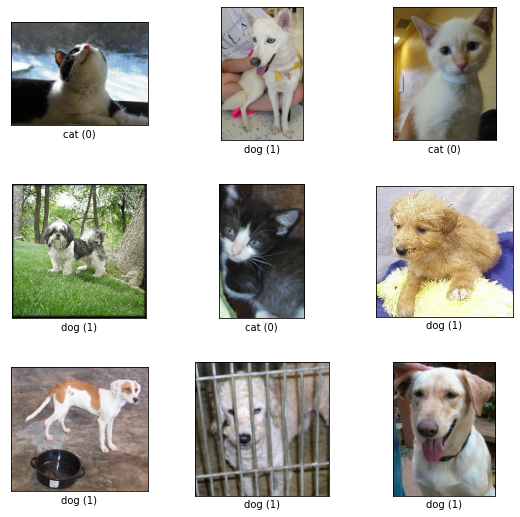

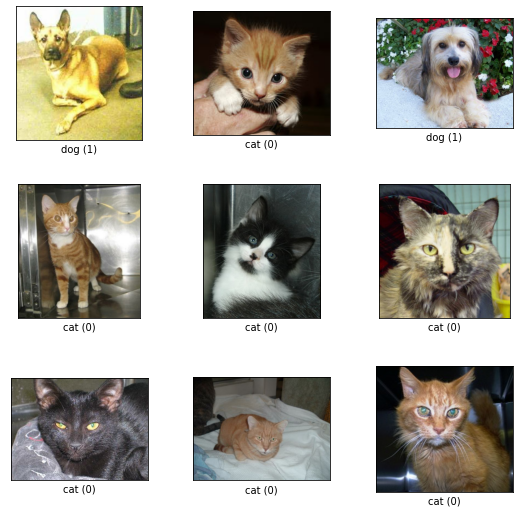

In [7]:
ds_info.features["label"].num_classes
ds_info.features["label"].names
fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_test, ds_info)

In [8]:
# 데이터셋에 정규화 및 리사이즈 적용
ds_train = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=16)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=16)

필터링 후 데이터셋 크기: 18610
필터링 후 데이터셋 크기: 4652


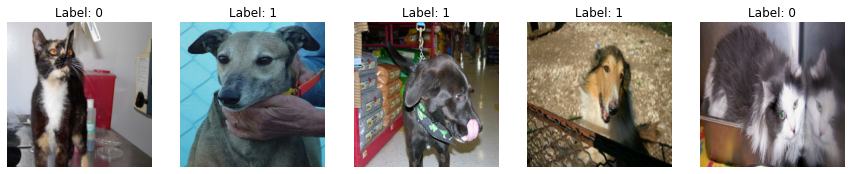

In [9]:
def visualize_samples(ds, num_samples=5):
    """주어진 데이터셋에서 샘플을 시각화합니다."""
    plt.figure(figsize=(15, 6))
    for i, (image_batch, label_batch) in enumerate(ds.take(1)):  # 1배치만 가져오기
        for j in range(num_samples):
            plt.subplot(1, num_samples, j + 1)
            plt.imshow(image_batch[j].numpy())  # 각 이미지에 대해 시각화
            plt.title("Label: {}".format(label_batch[j].numpy()))
            plt.axis('off')
    plt.show()

# 시각화 샘플
visualize_samples(ds_train)


## ResNet model 모듈화

In [10]:
class ResNetModels(Enum):
    RESNET_34 = 1
    RESNET_34_PLAIN = 2
    RESNET_50 = 3
    RESNET_50_PLAIN = 4

In [11]:
class HistorySaver(Callback):
    def __init__(self, model_type_name, checkpoint_dir):
        super(HistorySaver, self).__init__()
        self.model_type_name = model_type_name
        self.checkpoint_dir = checkpoint_dir
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        """에폭이 끝날 때마다 히스토리를 저장합니다."""
        self.history.append(logs)
        history_file_path = os.path.join(self.checkpoint_dir, f"{self.model_type_name}_history_epoch_{epoch+1}.pkl")
        with open(history_file_path, 'wb') as f:
            pickle.dump(self.history, f)
        print(f"에폭 {epoch + 1}의 히스토리가 저장되었습니다: {history_file_path}")


In [12]:
# EarlyStopping 지점을 기록하는 Custom Callback
class EarlyStoppingMonitor(Callback):
    def __init__(self, patience=3):
        super(EarlyStoppingMonitor, self).__init__()
        self.patience = patience
        self.best_weights = None
        self.best_epoch = None
        self.wait = 0
        self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if current_loss < self.best:
            self.best = current_loss
            self.best_epoch = epoch
            self.wait = 0  # 조건을 충족했으므로 대기 카운트 초기화
        else:
            self.wait += 1

        # 대기 카운트가 patience를 초과하면, EarlyStopping이 발생한 것으로 기록
        if self.wait > self.patience:
            print(f"Early stopping would have occurred at epoch {self.best_epoch + 1} (best val_loss: {self.best})")


In [13]:
class ResNet:
    def __init__(self, model_type: ResNetModels, input_shape=(244, 244, 3), num_cnn_list=[3, 4, 6, 3], channel_list=[64, 128, 256, 512]):
        self.input_shape = input_shape
        self.num_cnn_list = num_cnn_list
        self.channel_list = channel_list
        self.model_type = model_type
        self.model = self.build_resnet()

    def conv_block(self, input_layer, channel, kernel_size, strides=1, activation='relu'):
        """Convolutional block with Batch Normalization and Activation."""
        x = keras.layers.Conv2D(filters=channel,
                                 kernel_size=kernel_size,
                                 kernel_initializer='he_normal',
                                 kernel_regularizer=keras.regularizers.l2(1e-4),
                                 padding='same',
                                 strides=strides)(input_layer)
        # batch normalization 
        x = keras.layers.BatchNormalization()(x)
        # relu activation 
        x = keras.layers.Activation(activation)(x)
        return x

    def add_shortcut(self, x, num_cnn=3, channel=64, block_num=0):
        """Add shortcut connections and build blocks."""
        if self.model_type  == ResNetModels.RESNET_34:
            for i in range(num_cnn):
                if block_num > 0 and i == 0:
                    shortcut = self.conv_block(x, channel, (1, 1), strides=2, activation=None)
                    x = self.conv_block(x, channel, (3, 3), strides=2)
                    x = self.conv_block(x, channel, (3, 3), activation=None)
                else:
                    shortcut = x
                    x = self.conv_block(x, channel, (3, 3))
                    x = self.conv_block(x, channel, (3, 3), activation=None)

                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        
        elif self.model_type == ResNetModels.RESNET_34_PLAIN:
            for i in range(num_cnn):
                if block_num > 0 and i == 0:
                    #shortcut = self.conv_block(x, channel, (1, 1), strides=2, activation=None)
                    x = self.conv_block(x, channel, (3, 3), strides=2)
                    x = self.conv_block(x, channel, (3, 3), activation=None)
                else:
                   # shortcut = x
                    x = self.conv_block(x, channel, (3, 3))
                    x = self.conv_block(x, channel, (3, 3), activation=None)

                    #x = keras.layers.Add()([x, shortcut])
                    x = keras.layers.Activation('relu')(x)
        
        
        elif self.model_type == ResNetModels.RESNET_50:
            for i in range(num_cnn):
                if i == 0:
                    shortcut = self.conv_block(x, channel * 4, (1, 1), strides=2, activation=None)
                    x = self.conv_block(x, channel, (1, 1), strides=2)
                    x = self.conv_block(x, channel, (3, 3))
                    x = self.conv_block(x, channel * 4, (1, 1), activation=None)
                else:
                    shortcut = x
                    x = self.conv_block(x, channel, (1, 1))
                    x = self.conv_block(x, channel, (3, 3))
                    x = self.conv_block(x, channel * 4, (1, 1), activation=None)

                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        
        elif self.model_type ==  ResNetModels.RESNET_50_PLAIN:
            for i in range(num_cnn):
                if i == 0:
                  #  shortcut = self.conv_block(x, channel * 4, (1, 1), strides=2, activation=None)
                    x = self.conv_block(x, channel, (1, 1), strides=2)
                    x = self.conv_block(x, channel, (3, 3))
                    x = self.conv_block(x, channel * 4, (1, 1), activation=None)
                else:
                  #  shortcut = x
                    x = self.conv_block(x, channel, (1, 1))
                    x = self.conv_block(x, channel, (3, 3))
                    x = self.conv_block(x, channel * 4, (1, 1), activation=None)

                #x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
            
        return x

    def build_resnet(self):
        """Build the ResNet model."""
        assert len(self.num_cnn_list) == len(self.channel_list), "num_cnn_list와 channel_list의 길이가 같아야 합니다."

        input_layer = keras.layers.Input(shape=self.input_shape)
        x = self.conv_block(input_layer, 64, (7, 7), strides=2)
        x = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)  

        for block_num, (num_cnn, channel) in enumerate(zip(self.num_cnn_list, self.channel_list)):
            x = self.add_shortcut(x, num_cnn=num_cnn, channel=channel, block_num=block_num)

        x = keras.layers.AveragePooling2D(pool_size=(x.shape[1], x.shape[2]))(x)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(units=1, activation='sigmoid')(x)

        return keras.models.Model(inputs=input_layer, outputs=x)
    
    def compile(self, optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.), loss='binary_crossentropy', metrics=['accuracy']):
        """Compile the model."""
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    
    def fit(self, ds_train, epochs=10, validation_data=None, batch_size=32):
        """모델을 학습하고 히스토리를 반환합니다."""

        # 모델 타입에 따른 이름 지정
        model_type_name = {
            ResNetModels.RESNET_34: 'resnet34',
            ResNetModels.RESNET_34_PLAIN: 'resnet34_plain',
            ResNetModels.RESNET_50: 'resnet50',
            ResNetModels.RESNET_50_PLAIN: 'resnet50_plain'
        }[self.model_type]

        # Checkpoint 경로 설정
        checkpoint_dir = "./checkpoints"
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        # 모델 타입을 포함한 경로 설정
        checkpoint_path = os.path.join(checkpoint_dir, f"{model_type_name}_epoch_{{epoch:02d}}_val_acc_{{val_accuracy:.2f}}.h5")

        # ModelCheckpoint 콜백 설정
        checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                                     monitor='val_accuracy',
                                     save_best_only=False,  # 매 에포크마다 저장
                                     save_weights_only=False,  # 전체 모델 저장
                                     mode='max', 
                                     verbose=1)

        # HistorySaver 콜백 설정
        history_saver = HistorySaver(model_type_name, checkpoint_dir)

        # EarlyStoppingMonitor 콜백 추가
        early_stopping_monitor = EarlyStoppingMonitor(patience=3)

        # steps_per_epoch 및 validation_steps 계산
        total_samples_train = tf.data.experimental.cardinality(ds_train).numpy() * batch_size
        steps_per_epoch = total_samples_train // batch_size

        if validation_data is not None:
            total_samples_validation = tf.data.experimental.cardinality(validation_data).numpy() * batch_size
            validation_steps = total_samples_validation // batch_size
        else:
            validation_steps = None

        # 모델 학습 및 체크포인트 저장
        history = self.model.fit(
            ds_train,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_data,
            validation_steps=validation_steps,
            callbacks=[checkpoint, history_saver, early_stopping_monitor],  # EarlyStoppingMonitor 콜백 추가
            verbose=1
        )

        # 마지막 모델 저장
        final_model_path = os.path.join(checkpoint_dir, f"final_{model_type_name}.h5")
        self.model.save(final_model_path)  # 전체 모델 저장
        print(f"최종 모델이 저장되었습니다: {final_model_path}")

        return history




/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## model summary

In [14]:
resnet_34 = ResNet(model_type=ResNetModels.RESNET_34)

In [15]:
resnet_34.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 122, 122, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 122, 122, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 122, 122, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
resnet_50 = ResNet(model_type=ResNetModels.RESNET_50)

In [17]:
resnet_50.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 122, 122, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 122, 122, 64) 256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_52 (Activation)      (None, 122, 122, 64) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

## 시각화 함수

In [13]:
def compare_history_loss(history1, history2, label1, label2):
    # 손실(loss) 값을 error로 간주하여 플로팅
    train_loss1 = history1.history['loss']
    val_loss1 = history1.history['val_loss']
    train_loss2 = history2.history['loss']
    val_loss2 = history2.history['val_loss']
    
    epochs = range(1, len(train_loss1) + 1)

    plt.figure(figsize=(10, 6))
    
    # 첫 번째 모델 (얇은 곡선은 훈련 오류, 굵은 곡선은 검증 오류) - 빨간색 계열
    plt.plot(epochs, train_loss1, 'r-', label=f'{label1} train loss', linewidth=1)  # 얇은 훈련 곡선 (빨강)
    plt.plot(epochs, val_loss1, 'r-', label=f'{label1} val loss', linewidth=3, alpha=0.7)  # 굵은 검증 곡선 (빨강)
    
    # 두 번째 모델 (얇은 곡선은 훈련 오류, 굵은 곡선은 검증 오류) - 파란색 계열
    plt.plot(epochs, train_loss2, 'b-', label=f'{label2} train loss', linewidth=1)  # 얇은 훈련 곡선 (파랑)
    plt.plot(epochs, val_loss2, 'b-', label=f'{label2} val loss', linewidth=3, alpha=0.7)  # 굵은 검증 곡선 (파랑)
    
    # 그래프의 제목과 축 라벨 설정
    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # 범례 추가
    plt.legend()
    
    # 그래프 출력
    plt.show()


## resnet 34  모델 학습

In [14]:
for images, labels in ds_train.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (16, 244, 244, 3)
Labels shape: (16,)


In [15]:
resnet_34 = ResNet(model_type=ResNetModels.RESNET_34)

In [16]:
resnet_34.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# ds_train과 ds_test를 사용하여 학습 수행
resnet_34_history = resnet_34.fit(ds_train, epochs= 30, validation_data=ds_test)

Epoch 1/30
 190/1164 [===>..........................] - ETA: 1:56 - loss: 2.3950 - accuracy: 0.5602

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1164 [=====>........................] - ETA: 1:49 - loss: 2.3913 - accuracy: 0.5681

 280/1164 [======>.......................] - ETA: 1:46 - loss: 2.3882 - accuracy: 0.5728

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:28 - loss: 2.3832 - accuracy: 0.5790

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1164 [====================>.........] - ETA: 38s - loss: 2.3726 - accuracy: 0.5915

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1164 [=====================>........] - ETA: 35s - loss: 2.3718 - accuracy: 0.5930

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1164 [=====================>........] - ETA: 33s - loss: 2.3712 - accuracy: 0.5947

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1164 [=======================>......] - ETA: 26s - loss: 2.3702 - accuracy: 0.5971

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 953/1164 [=======================>......] - ETA: 25s - loss: 2.3701 - accuracy: 0.5971

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.3648 - accuracy: 0.6044

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 207s 130ms/step - loss: 2.3648 - accuracy: 0.6044 - val_loss: 2.3443 - val_accuracy: 0.6270

Epoch 00001: saving model to ./checkpoints/resnet34_epoch_01_val_acc_0.63.h5


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


에폭 1의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_1.pkl
Epoch 2/30
 194/1164 [====>.........................] - ETA: 1:56 - loss: 2.3340 - accuracy: 0.6366

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:49 - loss: 2.3359 - accuracy: 0.6374

 276/1164 [======>.......................] - ETA: 1:46 - loss: 2.3350 - accuracy: 0.6397

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1164 [==========>...................] - ETA: 1:28 - loss: 2.3369 - accuracy: 0.6357

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 837/1164 [====================>.........] - ETA: 39s - loss: 2.3368 - accuracy: 0.6355

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 36s - loss: 2.3363 - accuracy: 0.6360

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 884/1164 [=====================>........] - ETA: 33s - loss: 2.3365 - accuracy: 0.6358

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 938/1164 [=======================>......] - ETA: 27s - loss: 2.3359 - accuracy: 0.6364

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1164 [=======================>......] - ETA: 25s - loss: 2.3362 - accuracy: 0.6362

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.3339 - accuracy: 0.6384

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 2.3339 - accuracy: 0.6384 - val_loss: 2.3279 - val_accuracy: 0.6457

Epoch 00002: saving model to ./checkpoints/resnet34_epoch_02_val_acc_0.65.h5
에폭 2의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_2.pkl
Epoch 3/30
 194/1164 [====>.........................] - ETA: 1:56 - loss: 2.3098 - accuracy: 0.6649

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 251/1164 [=====>........................] - ETA: 1:49 - loss: 2.3110 - accuracy: 0.6628

 274/1164 [======>.......................] - ETA: 1:46 - loss: 2.3107 - accuracy: 0.6629

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 424/1164 [=========>....................] - ETA: 1:28 - loss: 2.3113 - accuracy: 0.6621

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 39s - loss: 2.3137 - accuracy: 0.6585

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 859/1164 [=====================>........] - ETA: 36s - loss: 2.3141 - accuracy: 0.6581

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 884/1164 [=====================>........] - ETA: 33s - loss: 2.3136 - accuracy: 0.6591

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 938/1164 [=======================>......] - ETA: 27s - loss: 2.3132 - accuracy: 0.6598

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1164 [=======================>......] - ETA: 25s - loss: 2.3130 - accuracy: 0.6603

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.3107 - accuracy: 0.6618

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 2.3107 - accuracy: 0.6618 - val_loss: 2.3211 - val_accuracy: 0.6582

Epoch 00003: saving model to ./checkpoints/resnet34_epoch_03_val_acc_0.66.h5
에폭 3의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_3.pkl
Epoch 4/30
 195/1164 [====>.........................] - ETA: 1:56 - loss: 2.2893 - accuracy: 0.6779

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:48 - loss: 2.2901 - accuracy: 0.6772

 275/1164 [======>.......................] - ETA: 1:46 - loss: 2.2881 - accuracy: 0.6786

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:28 - loss: 2.2838 - accuracy: 0.6815

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 837/1164 [====================>.........] - ETA: 39s - loss: 2.2897 - accuracy: 0.6809

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 36s - loss: 2.2891 - accuracy: 0.6825

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1164 [=====================>........] - ETA: 32s - loss: 2.2893 - accuracy: 0.6821

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1164 [=======================>......] - ETA: 26s - loss: 2.2877 - accuracy: 0.6836

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1164 [=======================>......] - ETA: 24s - loss: 2.2882 - accuracy: 0.6832

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.2863 - accuracy: 0.6853

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 2.2863 - accuracy: 0.6853 - val_loss: 2.3004 - val_accuracy: 0.6819

Epoch 00004: saving model to ./checkpoints/resnet34_epoch_04_val_acc_0.68.h5
에폭 4의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_4.pkl
Epoch 5/30
 194/1164 [====>.........................] - ETA: 1:56 - loss: 2.2439 - accuracy: 0.7245

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:49 - loss: 2.2509 - accuracy: 0.7130

 276/1164 [======>.......................] - ETA: 1:46 - loss: 2.2508 - accuracy: 0.7115

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:28 - loss: 2.2540 - accuracy: 0.7124

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 836/1164 [====================>.........] - ETA: 39s - loss: 2.2585 - accuracy: 0.7087

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 36s - loss: 2.2575 - accuracy: 0.7093

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 33s - loss: 2.2584 - accuracy: 0.7083

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 26s - loss: 2.2598 - accuracy: 0.7079

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 25s - loss: 2.2602 - accuracy: 0.7076

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.2578 - accuracy: 0.7111

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 2.2578 - accuracy: 0.7111 - val_loss: 2.3434 - val_accuracy: 0.6621

Epoch 00005: saving model to ./checkpoints/resnet34_epoch_05_val_acc_0.66.h5
에폭 5의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_5.pkl
Epoch 6/30
 190/1164 [===>..........................] - ETA: 1:56 - loss: 2.2021 - accuracy: 0.7553

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:48 - loss: 2.2037 - accuracy: 0.7539

 276/1164 [======>.......................] - ETA: 1:46 - loss: 2.2061 - accuracy: 0.7518

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:28 - loss: 2.2100 - accuracy: 0.7510

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 38s - loss: 2.2186 - accuracy: 0.7442

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 36s - loss: 2.2190 - accuracy: 0.7439

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 33s - loss: 2.2196 - accuracy: 0.7429

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 26s - loss: 2.2217 - accuracy: 0.7415

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 25s - loss: 2.2214 - accuracy: 0.7414

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.2185 - accuracy: 0.7437

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 2.2185 - accuracy: 0.7437 - val_loss: 2.3494 - val_accuracy: 0.6709

Epoch 00006: saving model to ./checkpoints/resnet34_epoch_06_val_acc_0.67.h5
에폭 6의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_6.pkl
Epoch 7/30
 196/1164 [====>.........................] - ETA: 1:55 - loss: 2.1551 - accuracy: 0.7902

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:48 - loss: 2.1573 - accuracy: 0.7870

 276/1164 [======>.......................] - ETA: 1:46 - loss: 2.1578 - accuracy: 0.7874

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:28 - loss: 2.1619 - accuracy: 0.7818

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 38s - loss: 2.1742 - accuracy: 0.7722

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 36s - loss: 2.1741 - accuracy: 0.7723

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 33s - loss: 2.1750 - accuracy: 0.7717

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 26s - loss: 2.1735 - accuracy: 0.7734

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 25s - loss: 2.1731 - accuracy: 0.7734

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1733 - accuracy: 0.7725

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 2.1733 - accuracy: 0.7725 - val_loss: 2.3221 - val_accuracy: 0.6855

Epoch 00007: saving model to ./checkpoints/resnet34_epoch_07_val_acc_0.69.h5
에폭 7의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_7.pkl
Epoch 8/30
 191/1164 [===>..........................] - ETA: 1:56 - loss: 2.1515 - accuracy: 0.7955

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 249/1164 [=====>........................] - ETA: 1:49 - loss: 2.1535 - accuracy: 0.7917

 274/1164 [======>.......................] - ETA: 1:46 - loss: 2.1500 - accuracy: 0.7961

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 421/1164 [=========>....................] - ETA: 1:28 - loss: 2.1522 - accuracy: 0.7914

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 38s - loss: 2.1578 - accuracy: 0.7849

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 859/1164 [=====================>........] - ETA: 36s - loss: 2.1585 - accuracy: 0.7846

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1164 [=====================>........] - ETA: 33s - loss: 2.1604 - accuracy: 0.7840

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1164 [=======================>......] - ETA: 26s - loss: 2.1608 - accuracy: 0.7834

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 953/1164 [=======================>......] - ETA: 25s - loss: 2.1603 - accuracy: 0.7836

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1583 - accuracy: 0.7835

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 2.1583 - accuracy: 0.7835 - val_loss: 2.3048 - val_accuracy: 0.6975

Epoch 00008: saving model to ./checkpoints/resnet34_epoch_08_val_acc_0.70.h5
에폭 8의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_8.pkl
Epoch 9/30
 191/1164 [===>..........................] - ETA: 1:56 - loss: 2.0690 - accuracy: 0.8459

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:49 - loss: 2.0665 - accuracy: 0.8477

 273/1164 [======>.......................] - ETA: 1:46 - loss: 2.0685 - accuracy: 0.8450

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1164 [=========>....................] - ETA: 1:28 - loss: 2.0695 - accuracy: 0.8445

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 836/1164 [====================>.........] - ETA: 39s - loss: 2.0875 - accuracy: 0.8269

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 859/1164 [=====================>........] - ETA: 36s - loss: 2.0894 - accuracy: 0.8260

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1164 [=====================>........] - ETA: 33s - loss: 2.0903 - accuracy: 0.8258

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1164 [=======================>......] - ETA: 26s - loss: 2.0922 - accuracy: 0.8253

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 953/1164 [=======================>......] - ETA: 25s - loss: 2.0922 - accuracy: 0.8253

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0964 - accuracy: 0.8224

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 2.0964 - accuracy: 0.8224 - val_loss: 2.3277 - val_accuracy: 0.6937

Epoch 00009: saving model to ./checkpoints/resnet34_epoch_09_val_acc_0.69.h5
에폭 9의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_9.pkl
Epoch 10/30
 193/1164 [===>..........................] - ETA: 1:56 - loss: 1.9953 - accuracy: 0.8964

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:48 - loss: 1.9886 - accuracy: 0.8979

 274/1164 [======>.......................] - ETA: 1:46 - loss: 1.9871 - accuracy: 0.8987

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 424/1164 [=========>....................] - ETA: 1:28 - loss: 2.0016 - accuracy: 0.8859

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 38s - loss: 2.0341 - accuracy: 0.8623

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 860/1164 [=====================>........] - ETA: 36s - loss: 2.0355 - accuracy: 0.8612

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 883/1164 [=====================>........] - ETA: 33s - loss: 2.0366 - accuracy: 0.8601

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 937/1164 [=======================>......] - ETA: 27s - loss: 2.0378 - accuracy: 0.8587

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 950/1164 [=======================>......] - ETA: 25s - loss: 2.0383 - accuracy: 0.8584

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0467 - accuracy: 0.8535

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 2.0467 - accuracy: 0.8535 - val_loss: 2.3522 - val_accuracy: 0.7003

Epoch 00010: saving model to ./checkpoints/resnet34_epoch_10_val_acc_0.70.h5
에폭 10의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_10.pkl
Epoch 11/30
 190/1164 [===>..........................] - ETA: 1:56 - loss: 1.9387 - accuracy: 0.9191

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:48 - loss: 1.9393 - accuracy: 0.9161

 278/1164 [======>.......................] - ETA: 1:46 - loss: 1.9387 - accuracy: 0.9161

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:28 - loss: 1.9434 - accuracy: 0.9115

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1164 [====================>.........] - ETA: 38s - loss: 1.9812 - accuracy: 0.8892

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1164 [=====================>........] - ETA: 35s - loss: 1.9839 - accuracy: 0.8882

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 33s - loss: 1.9867 - accuracy: 0.8866

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 26s - loss: 1.9897 - accuracy: 0.8847

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 25s - loss: 1.9895 - accuracy: 0.8848

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.9975 - accuracy: 0.8794

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.9975 - accuracy: 0.8794 - val_loss: 2.4401 - val_accuracy: 0.6907

Epoch 00011: saving model to ./checkpoints/resnet34_epoch_11_val_acc_0.69.h5
에폭 11의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_11.pkl
Epoch 12/30
 196/1164 [====>.........................] - ETA: 1:56 - loss: 1.8850 - accuracy: 0.9346

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:48 - loss: 1.8898 - accuracy: 0.9317

 274/1164 [======>.......................] - ETA: 1:46 - loss: 1.8885 - accuracy: 0.9327

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:28 - loss: 1.9036 - accuracy: 0.9251

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 38s - loss: 1.9431 - accuracy: 0.9046

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 860/1164 [=====================>........] - ETA: 36s - loss: 1.9455 - accuracy: 0.9033

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1164 [=====================>........] - ETA: 33s - loss: 1.9468 - accuracy: 0.9027

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1164 [=======================>......] - ETA: 26s - loss: 1.9515 - accuracy: 0.8999

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 953/1164 [=======================>......] - ETA: 25s - loss: 1.9517 - accuracy: 0.9001

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.9633 - accuracy: 0.8935

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.9633 - accuracy: 0.8935 - val_loss: 2.4914 - val_accuracy: 0.6885

Epoch 00012: saving model to ./checkpoints/resnet34_epoch_12_val_acc_0.69.h5
에폭 12의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_12.pkl
Epoch 13/30
 191/1164 [===>..........................] - ETA: 1:56 - loss: 1.8320 - accuracy: 0.9627

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1164 [=====>........................] - ETA: 1:48 - loss: 1.8363 - accuracy: 0.9600

 279/1164 [======>.......................] - ETA: 1:45 - loss: 1.8343 - accuracy: 0.9608

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:28 - loss: 1.8489 - accuracy: 0.9520

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 38s - loss: 1.9022 - accuracy: 0.9230

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1164 [=====================>........] - ETA: 35s - loss: 1.9042 - accuracy: 0.9215

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 884/1164 [=====================>........] - ETA: 33s - loss: 1.9056 - accuracy: 0.9210

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 938/1164 [=======================>......] - ETA: 27s - loss: 1.9110 - accuracy: 0.9186

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1164 [=======================>......] - ETA: 25s - loss: 1.9121 - accuracy: 0.9179

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.9261 - accuracy: 0.9112

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.9261 - accuracy: 0.9112 - val_loss: 2.4945 - val_accuracy: 0.6920

Epoch 00013: saving model to ./checkpoints/resnet34_epoch_13_val_acc_0.69.h5
에폭 13의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_13.pkl
Epoch 14/30
 190/1164 [===>..........................] - ETA: 1:56 - loss: 1.8093 - accuracy: 0.9714

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:48 - loss: 1.8110 - accuracy: 0.9701

 273/1164 [======>.......................] - ETA: 1:46 - loss: 1.8103 - accuracy: 0.9698

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:28 - loss: 1.8141 - accuracy: 0.9678

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 837/1164 [====================>.........] - ETA: 39s - loss: 1.8680 - accuracy: 0.9393

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 859/1164 [=====================>........] - ETA: 36s - loss: 1.8698 - accuracy: 0.9387

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 33s - loss: 1.8728 - accuracy: 0.9371

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 26s - loss: 1.8807 - accuracy: 0.9333

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 25s - loss: 1.8805 - accuracy: 0.9333

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.8872 - accuracy: 0.9287

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.8872 - accuracy: 0.9287 - val_loss: 2.5837 - val_accuracy: 0.6870

Epoch 00014: saving model to ./checkpoints/resnet34_epoch_14_val_acc_0.69.h5
에폭 14의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_14.pkl
Epoch 15/30
 190/1164 [===>..........................] - ETA: 1:56 - loss: 1.8778 - accuracy: 0.9293

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:48 - loss: 1.8843 - accuracy: 0.9284

 278/1164 [======>.......................] - ETA: 1:46 - loss: 1.8830 - accuracy: 0.9292

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:28 - loss: 1.8851 - accuracy: 0.9274

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 38s - loss: 1.9169 - accuracy: 0.9128

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1164 [=====================>........] - ETA: 36s - loss: 1.9184 - accuracy: 0.9118

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1164 [=====================>........] - ETA: 32s - loss: 1.9200 - accuracy: 0.9113

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1164 [=======================>......] - ETA: 26s - loss: 1.9214 - accuracy: 0.9113

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1164 [=======================>......] - ETA: 24s - loss: 1.9211 - accuracy: 0.9112

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.9238 - accuracy: 0.9092

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.9238 - accuracy: 0.9092 - val_loss: 2.5802 - val_accuracy: 0.6956

Epoch 00015: saving model to ./checkpoints/resnet34_epoch_15_val_acc_0.70.h5
에폭 15의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_15.pkl
Epoch 16/30
 194/1164 [====>.........................] - ETA: 1:55 - loss: 1.7746 - accuracy: 0.9784

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:49 - loss: 1.7779 - accuracy: 0.9767

 279/1164 [======>.......................] - ETA: 1:45 - loss: 1.7780 - accuracy: 0.9769

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 423/1164 [=========>....................] - ETA: 1:28 - loss: 1.7915 - accuracy: 0.9703

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 38s - loss: 1.8446 - accuracy: 0.9453

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1164 [=====================>........] - ETA: 35s - loss: 1.8462 - accuracy: 0.9444

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 883/1164 [=====================>........] - ETA: 33s - loss: 1.8479 - accuracy: 0.9439

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 937/1164 [=======================>......] - ETA: 27s - loss: 1.8500 - accuracy: 0.9430

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 950/1164 [=======================>......] - ETA: 25s - loss: 1.8502 - accuracy: 0.9428

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.8644 - accuracy: 0.9363

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.8644 - accuracy: 0.9363 - val_loss: 2.6338 - val_accuracy: 0.6883

Epoch 00016: saving model to ./checkpoints/resnet34_epoch_16_val_acc_0.69.h5
에폭 16의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_16.pkl
Epoch 17/30
 196/1164 [====>.........................] - ETA: 1:55 - loss: 1.7585 - accuracy: 0.9863

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:48 - loss: 1.7600 - accuracy: 0.9852

 275/1164 [======>.......................] - ETA: 1:46 - loss: 1.7600 - accuracy: 0.9845

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1164 [=========>....................] - ETA: 1:28 - loss: 1.7664 - accuracy: 0.9793

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 38s - loss: 1.8006 - accuracy: 0.9641

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 36s - loss: 1.8037 - accuracy: 0.9631

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 32s - loss: 1.8058 - accuracy: 0.9622

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 26s - loss: 1.8076 - accuracy: 0.9617

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 24s - loss: 1.8084 - accuracy: 0.9613

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.8184 - accuracy: 0.9573

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.8184 - accuracy: 0.9573 - val_loss: 2.9789 - val_accuracy: 0.6494

Epoch 00017: saving model to ./checkpoints/resnet34_epoch_17_val_acc_0.65.h5
에폭 17의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_17.pkl
Epoch 18/30
 193/1164 [===>..........................] - ETA: 1:56 - loss: 1.8295 - accuracy: 0.9475

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1164 [=====>........................] - ETA: 1:49 - loss: 1.8327 - accuracy: 0.9502

 275/1164 [======>.......................] - ETA: 1:46 - loss: 1.8315 - accuracy: 0.9509

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 423/1164 [=========>....................] - ETA: 1:28 - loss: 1.8445 - accuracy: 0.9471

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1164 [====================>.........] - ETA: 38s - loss: 1.8641 - accuracy: 0.9387

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 36s - loss: 1.8644 - accuracy: 0.9384

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 33s - loss: 1.8665 - accuracy: 0.9371

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 26s - loss: 1.8686 - accuracy: 0.9355

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 25s - loss: 1.8685 - accuracy: 0.9354

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.8708 - accuracy: 0.9341

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.8708 - accuracy: 0.9341 - val_loss: 2.9166 - val_accuracy: 0.6670

Epoch 00018: saving model to ./checkpoints/resnet34_epoch_18_val_acc_0.67.h5
에폭 18의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_18.pkl
Epoch 19/30
 190/1164 [===>..........................] - ETA: 1:56 - loss: 1.7417 - accuracy: 0.9888

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 251/1164 [=====>........................] - ETA: 1:49 - loss: 1.7400 - accuracy: 0.9895

 277/1164 [======>.......................] - ETA: 1:46 - loss: 1.7403 - accuracy: 0.9892

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:28 - loss: 1.7505 - accuracy: 0.9848

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 837/1164 [====================>.........] - ETA: 39s - loss: 1.7981 - accuracy: 0.9650

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 36s - loss: 1.8011 - accuracy: 0.9637

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 33s - loss: 1.8035 - accuracy: 0.9632

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 26s - loss: 1.8059 - accuracy: 0.9620

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 25s - loss: 1.8066 - accuracy: 0.9616

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.8179 - accuracy: 0.9560

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.8179 - accuracy: 0.9560 - val_loss: 2.8441 - val_accuracy: 0.6728

Epoch 00019: saving model to ./checkpoints/resnet34_epoch_19_val_acc_0.67.h5
에폭 19의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_19.pkl
Epoch 20/30
 189/1164 [===>..........................] - ETA: 1:56 - loss: 1.7200 - accuracy: 0.9947

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:48 - loss: 1.7210 - accuracy: 0.9934

 275/1164 [======>.......................] - ETA: 1:46 - loss: 1.7206 - accuracy: 0.9936

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:28 - loss: 1.7307 - accuracy: 0.9902

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 38s - loss: 1.7682 - accuracy: 0.9757

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 36s - loss: 1.7711 - accuracy: 0.9746

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1164 [=====================>........] - ETA: 33s - loss: 1.7720 - accuracy: 0.9745

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1164 [=======================>......] - ETA: 26s - loss: 1.7736 - accuracy: 0.9738

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 953/1164 [=======================>......] - ETA: 25s - loss: 1.7747 - accuracy: 0.9736

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.7801 - accuracy: 0.9713

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.7801 - accuracy: 0.9713 - val_loss: 3.1570 - val_accuracy: 0.6782

Epoch 00020: saving model to ./checkpoints/resnet34_epoch_20_val_acc_0.68.h5
에폭 20의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_20.pkl
Epoch 21/30
 190/1164 [===>..........................] - ETA: 1:56 - loss: 1.7248 - accuracy: 0.9928

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:48 - loss: 1.7246 - accuracy: 0.9924

 275/1164 [======>.......................] - ETA: 1:46 - loss: 1.7266 - accuracy: 0.9914

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1164 [=========>....................] - ETA: 1:28 - loss: 1.7374 - accuracy: 0.9868

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1164 [====================>.........] - ETA: 38s - loss: 1.7728 - accuracy: 0.9725

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 36s - loss: 1.7745 - accuracy: 0.9719

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 883/1164 [=====================>........] - ETA: 33s - loss: 1.7761 - accuracy: 0.9709

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 937/1164 [=======================>......] - ETA: 27s - loss: 1.7792 - accuracy: 0.9694

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 950/1164 [=======================>......] - ETA: 25s - loss: 1.7802 - accuracy: 0.9689

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.7932 - accuracy: 0.9635

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.7932 - accuracy: 0.9635 - val_loss: 2.9912 - val_accuracy: 0.6773

Epoch 00021: saving model to ./checkpoints/resnet34_epoch_21_val_acc_0.68.h5
에폭 21의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_21.pkl
Epoch 22/30
 194/1164 [====>.........................] - ETA: 1:56 - loss: 1.7192 - accuracy: 0.9945

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:48 - loss: 1.7206 - accuracy: 0.9939

 274/1164 [======>.......................] - ETA: 1:46 - loss: 1.7227 - accuracy: 0.9936

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 422/1164 [=========>....................] - ETA: 1:28 - loss: 1.7266 - accuracy: 0.9916

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 38s - loss: 1.7572 - accuracy: 0.9798

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 860/1164 [=====================>........] - ETA: 36s - loss: 1.7589 - accuracy: 0.9791

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 33s - loss: 1.7590 - accuracy: 0.9790

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 26s - loss: 1.7625 - accuracy: 0.9776

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 25s - loss: 1.7632 - accuracy: 0.9774

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.7707 - accuracy: 0.9748

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.7707 - accuracy: 0.9748 - val_loss: 2.8487 - val_accuracy: 0.6967

Epoch 00022: saving model to ./checkpoints/resnet34_epoch_22_val_acc_0.70.h5
에폭 22의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_22.pkl
Epoch 23/30
 190/1164 [===>..........................] - ETA: 1:56 - loss: 1.7190 - accuracy: 0.9924

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:49 - loss: 1.7194 - accuracy: 0.9921

 275/1164 [======>.......................] - ETA: 1:46 - loss: 1.7190 - accuracy: 0.9923

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:28 - loss: 1.7223 - accuracy: 0.9915

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1164 [====================>.........] - ETA: 38s - loss: 1.7450 - accuracy: 0.9827

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 36s - loss: 1.7458 - accuracy: 0.9824

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 883/1164 [=====================>........] - ETA: 33s - loss: 1.7458 - accuracy: 0.9824

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 937/1164 [=======================>......] - ETA: 27s - loss: 1.7475 - accuracy: 0.9818

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 950/1164 [=======================>......] - ETA: 25s - loss: 1.7489 - accuracy: 0.9814

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.7545 - accuracy: 0.9791

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.7545 - accuracy: 0.9791 - val_loss: 3.1899 - val_accuracy: 0.6825

Epoch 00023: saving model to ./checkpoints/resnet34_epoch_23_val_acc_0.68.h5
에폭 23의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_23.pkl
Epoch 24/30
 190/1164 [===>..........................] - ETA: 1:56 - loss: 1.7481 - accuracy: 0.9826

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 251/1164 [=====>........................] - ETA: 1:49 - loss: 1.7459 - accuracy: 0.9833

 276/1164 [======>.......................] - ETA: 1:46 - loss: 1.7503 - accuracy: 0.9819

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:28 - loss: 1.7552 - accuracy: 0.9791

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 38s - loss: 1.7678 - accuracy: 0.9736

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 36s - loss: 1.7679 - accuracy: 0.9735

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 33s - loss: 1.7679 - accuracy: 0.9736

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 26s - loss: 1.7680 - accuracy: 0.9734

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 25s - loss: 1.7682 - accuracy: 0.9733

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.7710 - accuracy: 0.9721

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.7710 - accuracy: 0.9721 - val_loss: 3.0101 - val_accuracy: 0.6956

Epoch 00024: saving model to ./checkpoints/resnet34_epoch_24_val_acc_0.70.h5
에폭 24의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_24.pkl
Epoch 25/30
 191/1164 [===>..........................] - ETA: 1:56 - loss: 1.7245 - accuracy: 0.9912

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:49 - loss: 1.7223 - accuracy: 0.9924

 273/1164 [======>.......................] - ETA: 1:46 - loss: 1.7211 - accuracy: 0.9929

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 423/1164 [=========>....................] - ETA: 1:28 - loss: 1.7256 - accuracy: 0.9914

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 38s - loss: 1.7458 - accuracy: 0.9835

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 859/1164 [=====================>........] - ETA: 36s - loss: 1.7458 - accuracy: 0.9836

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 33s - loss: 1.7476 - accuracy: 0.9829

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 26s - loss: 1.7491 - accuracy: 0.9824

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 25s - loss: 1.7497 - accuracy: 0.9820

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.7541 - accuracy: 0.9794

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.7541 - accuracy: 0.9794 - val_loss: 3.3969 - val_accuracy: 0.6477

Epoch 00025: saving model to ./checkpoints/resnet34_epoch_25_val_acc_0.65.h5
에폭 25의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_25.pkl
Epoch 26/30
 191/1164 [===>..........................] - ETA: 1:56 - loss: 1.7405 - accuracy: 0.9872

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:49 - loss: 1.7430 - accuracy: 0.9861

 277/1164 [======>.......................] - ETA: 1:46 - loss: 1.7416 - accuracy: 0.9869

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1164 [==========>...................] - ETA: 1:28 - loss: 1.7456 - accuracy: 0.9853

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 38s - loss: 1.7628 - accuracy: 0.9775

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 36s - loss: 1.7630 - accuracy: 0.9775

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 33s - loss: 1.7649 - accuracy: 0.9767

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 26s - loss: 1.7673 - accuracy: 0.9756

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 25s - loss: 1.7679 - accuracy: 0.9753

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.7698 - accuracy: 0.9738

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.7698 - accuracy: 0.9738 - val_loss: 3.0104 - val_accuracy: 0.7036

Epoch 00026: saving model to ./checkpoints/resnet34_epoch_26_val_acc_0.70.h5
에폭 26의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_26.pkl
Epoch 27/30
 194/1164 [====>.........................] - ETA: 1:55 - loss: 1.7171 - accuracy: 0.9903

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1164 [=====>........................] - ETA: 1:48 - loss: 1.7163 - accuracy: 0.9910

 276/1164 [======>.......................] - ETA: 1:46 - loss: 1.7169 - accuracy: 0.9912

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1164 [==========>...................] - ETA: 1:28 - loss: 1.7220 - accuracy: 0.9898

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 836/1164 [====================>.........] - ETA: 39s - loss: 1.7403 - accuracy: 0.9831

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 36s - loss: 1.7408 - accuracy: 0.9829

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 33s - loss: 1.7413 - accuracy: 0.9827

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 26s - loss: 1.7436 - accuracy: 0.9822

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 25s - loss: 1.7447 - accuracy: 0.9819

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.7510 - accuracy: 0.9793

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.7510 - accuracy: 0.9793 - val_loss: 2.9827 - val_accuracy: 0.6995

Epoch 00027: saving model to ./checkpoints/resnet34_epoch_27_val_acc_0.70.h5
에폭 27의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_27.pkl
Epoch 28/30
 195/1164 [====>.........................] - ETA: 1:56 - loss: 1.7025 - accuracy: 0.9974

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1164 [=====>........................] - ETA: 1:49 - loss: 1.7043 - accuracy: 0.9963

 277/1164 [======>.......................] - ETA: 1:46 - loss: 1.7044 - accuracy: 0.9964

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 423/1164 [=========>....................] - ETA: 1:28 - loss: 1.7104 - accuracy: 0.9939

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 835/1164 [====================>.........] - ETA: 39s - loss: 1.7290 - accuracy: 0.9880

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 36s - loss: 1.7299 - accuracy: 0.9877

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 33s - loss: 1.7296 - accuracy: 0.9879

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 26s - loss: 1.7311 - accuracy: 0.9872

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 25s - loss: 1.7319 - accuracy: 0.9870

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.7375 - accuracy: 0.9841

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.7375 - accuracy: 0.9841 - val_loss: 3.1131 - val_accuracy: 0.6883

Epoch 00028: saving model to ./checkpoints/resnet34_epoch_28_val_acc_0.69.h5
에폭 28의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_28.pkl
Epoch 29/30
 192/1164 [===>..........................] - ETA: 1:56 - loss: 1.7060 - accuracy: 0.9961

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1164 [=====>........................] - ETA: 1:48 - loss: 1.7079 - accuracy: 0.9948

 281/1164 [======>.......................] - ETA: 1:45 - loss: 1.7085 - accuracy: 0.9949

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1164 [=========>....................] - ETA: 1:28 - loss: 1.7118 - accuracy: 0.9937

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1164 [====================>.........] - ETA: 38s - loss: 1.7311 - accuracy: 0.9860

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1164 [=====================>........] - ETA: 35s - loss: 1.7325 - accuracy: 0.9856

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 883/1164 [=====================>........] - ETA: 33s - loss: 1.7332 - accuracy: 0.9852

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 937/1164 [=======================>......] - ETA: 27s - loss: 1.7340 - accuracy: 0.9845

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 950/1164 [=======================>......] - ETA: 25s - loss: 1.7349 - accuracy: 0.9842

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.7419 - accuracy: 0.9823

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.7419 - accuracy: 0.9823 - val_loss: 3.0874 - val_accuracy: 0.6915

Epoch 00029: saving model to ./checkpoints/resnet34_epoch_29_val_acc_0.69.h5
에폭 29의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_29.pkl
Epoch 30/30
 190/1164 [===>..........................] - ETA: 1:56 - loss: 1.8514 - accuracy: 0.9487

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:48 - loss: 1.8608 - accuracy: 0.9446

 280/1164 [======>.......................] - ETA: 1:45 - loss: 1.8582 - accuracy: 0.9464

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:28 - loss: 1.8464 - accuracy: 0.9479

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1164 [====================>.........] - ETA: 38s - loss: 1.8182 - accuracy: 0.9557

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1164 [=====================>........] - ETA: 35s - loss: 1.8186 - accuracy: 0.9556

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 33s - loss: 1.8168 - accuracy: 0.9562

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1164 [=======================>......] - ETA: 26s - loss: 1.8135 - accuracy: 0.9572

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 25s - loss: 1.8135 - accuracy: 0.9573

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.8093 - accuracy: 0.9584

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 152s 128ms/step - loss: 1.8093 - accuracy: 0.9584 - val_loss: 2.9750 - val_accuracy: 0.6999

Epoch 00030: saving model to ./checkpoints/resnet34_epoch_30_val_acc_0.70.h5
에폭 30의 히스토리가 저장되었습니다: ./checkpoints/resnet34_history_epoch_30.pkl
최종 모델이 저장되었습니다: ./checkpoints/final_resnet34.h5


In [18]:
resnet_34_plain = ResNet(model_type=ResNetModels.RESNET_34_PLAIN)

In [20]:
resnet_34_plain.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
resnet_34_plain_history = resnet_34_plain.fit(ds_train, epochs = 30, validation_data = ds_test)

Epoch 1/30
 190/1164 [===>..........................] - ETA: 1:50 - loss: 2.2162 - accuracy: 0.5319

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1164 [=====>........................] - ETA: 1:43 - loss: 2.2143 - accuracy: 0.5376

 277/1164 [======>.......................] - ETA: 1:40 - loss: 2.2130 - accuracy: 0.5406

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 422/1164 [=========>....................] - ETA: 1:24 - loss: 2.2138 - accuracy: 0.5369

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 37s - loss: 2.2123 - accuracy: 0.5418

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1164 [=====================>........] - ETA: 34s - loss: 2.2121 - accuracy: 0.5427

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 31s - loss: 2.2120 - accuracy: 0.5429

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 25s - loss: 2.2119 - accuracy: 0.5426

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 24s - loss: 2.2118 - accuracy: 0.5427

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.2113 - accuracy: 0.5439

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 151s 122ms/step - loss: 2.2113 - accuracy: 0.5439 - val_loss: 2.2151 - val_accuracy: 0.5301

Epoch 00001: saving model to ./checkpoints/resnet34_plain_epoch_01_val_acc_0.53.h5
에폭 1의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_1.pkl
Epoch 2/30
 196/1164 [====>.........................] - ETA: 1:50 - loss: 2.2089 - accuracy: 0.5555

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:43 - loss: 2.2079 - accuracy: 0.5605

 279/1164 [======>.......................] - ETA: 1:40 - loss: 2.2077 - accuracy: 0.5605

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1164 [=========>....................] - ETA: 1:24 - loss: 2.2082 - accuracy: 0.5546

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 837/1164 [====================>.........] - ETA: 37s - loss: 2.2075 - accuracy: 0.5559

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1164 [=====================>........] - ETA: 34s - loss: 2.2077 - accuracy: 0.5550

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 884/1164 [=====================>........] - ETA: 31s - loss: 2.2075 - accuracy: 0.5554

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 938/1164 [=======================>......] - ETA: 25s - loss: 2.2076 - accuracy: 0.5559

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1164 [=======================>......] - ETA: 24s - loss: 2.2078 - accuracy: 0.5553

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.2077 - accuracy: 0.5551

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.2077 - accuracy: 0.5551 - val_loss: 2.2074 - val_accuracy: 0.5503

Epoch 00002: saving model to ./checkpoints/resnet34_plain_epoch_02_val_acc_0.55.h5
에폭 2의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_2.pkl
Epoch 3/30
 189/1164 [===>..........................] - ETA: 1:50 - loss: 2.2093 - accuracy: 0.5460

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:43 - loss: 2.2073 - accuracy: 0.5534

 275/1164 [======>.......................] - ETA: 1:41 - loss: 2.2072 - accuracy: 0.5525

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1164 [=========>....................] - ETA: 1:23 - loss: 2.2062 - accuracy: 0.5565

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 836/1164 [====================>.........] - ETA: 37s - loss: 2.2064 - accuracy: 0.5543

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 34s - loss: 2.2062 - accuracy: 0.5557

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 31s - loss: 2.2063 - accuracy: 0.5555

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 25s - loss: 2.2062 - accuracy: 0.5555

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 23s - loss: 2.2061 - accuracy: 0.5558

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.2062 - accuracy: 0.5548

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.2062 - accuracy: 0.5548 - val_loss: 2.2056 - val_accuracy: 0.5593

Epoch 00003: saving model to ./checkpoints/resnet34_plain_epoch_03_val_acc_0.56.h5
에폭 3의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_3.pkl
Epoch 4/30
 194/1164 [====>.........................] - ETA: 1:50 - loss: 2.2053 - accuracy: 0.5535

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1164 [=====>........................] - ETA: 1:43 - loss: 2.2062 - accuracy: 0.5606

 279/1164 [======>.......................] - ETA: 1:40 - loss: 2.2059 - accuracy: 0.5612

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 423/1164 [=========>....................] - ETA: 1:24 - loss: 2.2034 - accuracy: 0.5625

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1164 [====================>.........] - ETA: 36s - loss: 2.2042 - accuracy: 0.5589

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1164 [=====================>........] - ETA: 34s - loss: 2.2041 - accuracy: 0.5597

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1164 [=====================>........] - ETA: 31s - loss: 2.2041 - accuracy: 0.5600

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1164 [=======================>......] - ETA: 25s - loss: 2.2035 - accuracy: 0.5623

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 953/1164 [=======================>......] - ETA: 24s - loss: 2.2037 - accuracy: 0.5617

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.2029 - accuracy: 0.5641

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.2029 - accuracy: 0.5641 - val_loss: 2.2041 - val_accuracy: 0.5608

Epoch 00004: saving model to ./checkpoints/resnet34_plain_epoch_04_val_acc_0.56.h5
에폭 4의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_4.pkl
Epoch 5/30
 195/1164 [====>.........................] - ETA: 1:49 - loss: 2.2012 - accuracy: 0.5708

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:43 - loss: 2.2013 - accuracy: 0.5706

 274/1164 [======>.......................] - ETA: 1:41 - loss: 2.2013 - accuracy: 0.5698

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:24 - loss: 2.2008 - accuracy: 0.5685

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 36s - loss: 2.1996 - accuracy: 0.5732

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 860/1164 [=====================>........] - ETA: 34s - loss: 2.1996 - accuracy: 0.5730

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 31s - loss: 2.1996 - accuracy: 0.5736

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 25s - loss: 2.1999 - accuracy: 0.5727

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 24s - loss: 2.1999 - accuracy: 0.5731

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1996 - accuracy: 0.5728

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 144s 122ms/step - loss: 2.1996 - accuracy: 0.5728 - val_loss: 2.1997 - val_accuracy: 0.5724

Epoch 00005: saving model to ./checkpoints/resnet34_plain_epoch_05_val_acc_0.57.h5
에폭 5의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_5.pkl
Epoch 6/30
 190/1164 [===>..........................] - ETA: 1:50 - loss: 2.1967 - accuracy: 0.5786

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:43 - loss: 2.1965 - accuracy: 0.5795

 279/1164 [======>.......................] - ETA: 1:40 - loss: 2.1966 - accuracy: 0.5804

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:24 - loss: 2.1970 - accuracy: 0.5768

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1164 [====================>.........] - ETA: 36s - loss: 2.1962 - accuracy: 0.5810

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1164 [=====================>........] - ETA: 34s - loss: 2.1963 - accuracy: 0.5809

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 31s - loss: 2.1964 - accuracy: 0.5800

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 25s - loss: 2.1959 - accuracy: 0.5815

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 23s - loss: 2.1959 - accuracy: 0.5814

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1953 - accuracy: 0.5817

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.1953 - accuracy: 0.5817 - val_loss: 2.1930 - val_accuracy: 0.5879

Epoch 00006: saving model to ./checkpoints/resnet34_plain_epoch_06_val_acc_0.59.h5
에폭 6의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_6.pkl
Epoch 7/30
 194/1164 [====>.........................] - ETA: 1:50 - loss: 2.1931 - accuracy: 0.5867

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1164 [=====>........................] - ETA: 1:43 - loss: 2.1937 - accuracy: 0.5879

 276/1164 [======>.......................] - ETA: 1:41 - loss: 2.1941 - accuracy: 0.5885

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 423/1164 [=========>....................] - ETA: 1:24 - loss: 2.1913 - accuracy: 0.5950

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 37s - loss: 2.1906 - accuracy: 0.5931

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 34s - loss: 2.1907 - accuracy: 0.5935

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 31s - loss: 2.1905 - accuracy: 0.5938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 25s - loss: 2.1902 - accuracy: 0.5941

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 23s - loss: 2.1901 - accuracy: 0.5942

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1884 - accuracy: 0.5956

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.1884 - accuracy: 0.5956 - val_loss: 2.1866 - val_accuracy: 0.5909

Epoch 00007: saving model to ./checkpoints/resnet34_plain_epoch_07_val_acc_0.59.h5
에폭 7의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_7.pkl
Epoch 8/30
 888/1164 [=====================>........] - ETA: 31s - loss: 2.1797 - accuracy: 0.6087

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 25s - loss: 2.1786 - accuracy: 0.6107

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 23s - loss: 2.1786 - accuracy: 0.6107

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1768 - accuracy: 0.6103

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.1768 - accuracy: 0.6103 - val_loss: 2.1775 - val_accuracy: 0.6191

Epoch 00008: saving model to ./checkpoints/resnet34_plain_epoch_08_val_acc_0.62.h5
에폭 8의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_8.pkl
Epoch 9/30
 192/1164 [===>..........................] - ETA: 1:50 - loss: 2.1648 - accuracy: 0.6328

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:43 - loss: 2.1611 - accuracy: 0.6339

 273/1164 [======>.......................] - ETA: 1:41 - loss: 2.1635 - accuracy: 0.6326

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 423/1164 [=========>....................] - ETA: 1:24 - loss: 2.1651 - accuracy: 0.6309

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1164 [====================>.........] - ETA: 37s - loss: 2.1638 - accuracy: 0.6311

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 859/1164 [=====================>........] - ETA: 34s - loss: 2.1634 - accuracy: 0.6320

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 31s - loss: 2.1632 - accuracy: 0.6319

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 25s - loss: 2.1623 - accuracy: 0.6328

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 23s - loss: 2.1625 - accuracy: 0.6327

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1621 - accuracy: 0.6326

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 144s 122ms/step - loss: 2.1621 - accuracy: 0.6326 - val_loss: 2.1694 - val_accuracy: 0.6253

Epoch 00009: saving model to ./checkpoints/resnet34_plain_epoch_09_val_acc_0.63.h5
에폭 9의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_9.pkl
Epoch 10/30
 195/1164 [====>.........................] - ETA: 1:50 - loss: 2.1563 - accuracy: 0.6381

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:43 - loss: 2.1591 - accuracy: 0.6364

 275/1164 [======>.......................] - ETA: 1:41 - loss: 2.1601 - accuracy: 0.6332

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:24 - loss: 2.1628 - accuracy: 0.6265

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 837/1164 [====================>.........] - ETA: 37s - loss: 2.1585 - accuracy: 0.6345

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 860/1164 [=====================>........] - ETA: 34s - loss: 2.1572 - accuracy: 0.6363

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 883/1164 [=====================>........] - ETA: 31s - loss: 2.1563 - accuracy: 0.6367

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 937/1164 [=======================>......] - ETA: 25s - loss: 2.1557 - accuracy: 0.6365

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 950/1164 [=======================>......] - ETA: 24s - loss: 2.1559 - accuracy: 0.6365

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1552 - accuracy: 0.6364

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.1552 - accuracy: 0.6364 - val_loss: 2.1676 - val_accuracy: 0.6378

Epoch 00010: saving model to ./checkpoints/resnet34_plain_epoch_10_val_acc_0.64.h5
에폭 10의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_10.pkl
Epoch 11/30
 196/1164 [====>.........................] - ETA: 1:49 - loss: 2.1526 - accuracy: 0.6464

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1164 [=====>........................] - ETA: 1:43 - loss: 2.1499 - accuracy: 0.6470

 278/1164 [======>.......................] - ETA: 1:40 - loss: 2.1490 - accuracy: 0.6482

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:23 - loss: 2.1486 - accuracy: 0.6465

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 836/1164 [====================>.........] - ETA: 37s - loss: 2.1478 - accuracy: 0.6486

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1164 [=====================>........] - ETA: 34s - loss: 2.1465 - accuracy: 0.6498

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 31s - loss: 2.1455 - accuracy: 0.6508

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 25s - loss: 2.1456 - accuracy: 0.6506

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 24s - loss: 2.1461 - accuracy: 0.6499

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1454 - accuracy: 0.6499

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.1454 - accuracy: 0.6499 - val_loss: 2.1632 - val_accuracy: 0.6346

Epoch 00011: saving model to ./checkpoints/resnet34_plain_epoch_11_val_acc_0.63.h5
에폭 11의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_11.pkl
Epoch 12/30
 191/1164 [===>..........................] - ETA: 1:50 - loss: 2.1455 - accuracy: 0.6427

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 251/1164 [=====>........................] - ETA: 1:43 - loss: 2.1440 - accuracy: 0.6444

 277/1164 [======>.......................] - ETA: 1:40 - loss: 2.1421 - accuracy: 0.6460

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 424/1164 [=========>....................] - ETA: 1:24 - loss: 2.1465 - accuracy: 0.6415

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1164 [====================>.........] - ETA: 36s - loss: 2.1455 - accuracy: 0.6460

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 34s - loss: 2.1445 - accuracy: 0.6478

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 883/1164 [=====================>........] - ETA: 31s - loss: 2.1450 - accuracy: 0.6477

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 937/1164 [=======================>......] - ETA: 25s - loss: 2.1452 - accuracy: 0.6472

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 950/1164 [=======================>......] - ETA: 24s - loss: 2.1449 - accuracy: 0.6474

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1422 - accuracy: 0.6499

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 144s 122ms/step - loss: 2.1422 - accuracy: 0.6499 - val_loss: 2.1509 - val_accuracy: 0.6498

Epoch 00012: saving model to ./checkpoints/resnet34_plain_epoch_12_val_acc_0.65.h5
에폭 12의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_12.pkl
Epoch 13/30
 194/1164 [====>.........................] - ETA: 1:50 - loss: 2.1312 - accuracy: 0.6550

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1164 [=====>........................] - ETA: 1:43 - loss: 2.1313 - accuracy: 0.6556

 279/1164 [======>.......................] - ETA: 1:40 - loss: 2.1322 - accuracy: 0.6530

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:24 - loss: 2.1343 - accuracy: 0.6526

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 835/1164 [====================>.........] - ETA: 37s - loss: 2.1384 - accuracy: 0.6534

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1164 [=====================>........] - ETA: 34s - loss: 2.1376 - accuracy: 0.6540

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 31s - loss: 2.1373 - accuracy: 0.6542

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 25s - loss: 2.1367 - accuracy: 0.6551

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 24s - loss: 2.1363 - accuracy: 0.6553

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1358 - accuracy: 0.6548

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.1358 - accuracy: 0.6548 - val_loss: 2.1538 - val_accuracy: 0.6539

Epoch 00013: saving model to ./checkpoints/resnet34_plain_epoch_13_val_acc_0.65.h5
에폭 13의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_13.pkl
Epoch 14/30
 192/1164 [===>..........................] - ETA: 1:50 - loss: 2.1371 - accuracy: 0.6579

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1164 [=====>........................] - ETA: 1:43 - loss: 2.1338 - accuracy: 0.6554

 274/1164 [======>.......................] - ETA: 1:41 - loss: 2.1315 - accuracy: 0.6597

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1164 [=========>....................] - ETA: 1:24 - loss: 2.1341 - accuracy: 0.6573

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1164 [====================>.........] - ETA: 36s - loss: 2.1318 - accuracy: 0.6607

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 860/1164 [=====================>........] - ETA: 34s - loss: 2.1311 - accuracy: 0.6615

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 31s - loss: 2.1313 - accuracy: 0.6610

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 25s - loss: 2.1306 - accuracy: 0.6616

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 23s - loss: 2.1298 - accuracy: 0.6624

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1285 - accuracy: 0.6644

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.1285 - accuracy: 0.6644 - val_loss: 2.2012 - val_accuracy: 0.6543

Epoch 00014: saving model to ./checkpoints/resnet34_plain_epoch_14_val_acc_0.65.h5
에폭 14의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_14.pkl
Epoch 15/30
 841/1164 [====================>.........] - ETA: 36s - loss: 2.1267 - accuracy: 0.6671

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1164 [=====================>........] - ETA: 34s - loss: 2.1264 - accuracy: 0.6666

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 31s - loss: 2.1268 - accuracy: 0.6669

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 25s - loss: 2.1260 - accuracy: 0.6681

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 23s - loss: 2.1261 - accuracy: 0.6677

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1237 - accuracy: 0.6697

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 144s 122ms/step - loss: 2.1237 - accuracy: 0.6697 - val_loss: 2.1729 - val_accuracy: 0.6397

Epoch 00015: saving model to ./checkpoints/resnet34_plain_epoch_15_val_acc_0.64.h5
에폭 15의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_15.pkl
Epoch 16/30
 193/1164 [===>..........................] - ETA: 1:50 - loss: 2.1156 - accuracy: 0.6762

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:43 - loss: 2.1145 - accuracy: 0.6754

 273/1164 [======>.......................] - ETA: 1:41 - loss: 2.1147 - accuracy: 0.6767

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 424/1164 [=========>....................] - ETA: 1:24 - loss: 2.1165 - accuracy: 0.6747

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 36s - loss: 2.1152 - accuracy: 0.6774

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 859/1164 [=====================>........] - ETA: 34s - loss: 2.1144 - accuracy: 0.6775

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 884/1164 [=====================>........] - ETA: 31s - loss: 2.1145 - accuracy: 0.6777

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 938/1164 [=======================>......] - ETA: 25s - loss: 2.1143 - accuracy: 0.6772

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1164 [=======================>......] - ETA: 24s - loss: 2.1145 - accuracy: 0.6763

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1126 - accuracy: 0.6786

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 144s 122ms/step - loss: 2.1126 - accuracy: 0.6786 - val_loss: 2.1449 - val_accuracy: 0.6541

Epoch 00016: saving model to ./checkpoints/resnet34_plain_epoch_16_val_acc_0.65.h5
에폭 16의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_16.pkl
Epoch 17/30
 193/1164 [===>..........................] - ETA: 1:50 - loss: 2.1115 - accuracy: 0.6765

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:43 - loss: 2.1105 - accuracy: 0.6791

 273/1164 [======>.......................] - ETA: 1:41 - loss: 2.1113 - accuracy: 0.6779

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1164 [=========>....................] - ETA: 1:24 - loss: 2.1180 - accuracy: 0.6734

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 837/1164 [====================>.........] - ETA: 37s - loss: 2.1124 - accuracy: 0.6769

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 859/1164 [=====================>........] - ETA: 34s - loss: 2.1119 - accuracy: 0.6774

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 31s - loss: 2.1117 - accuracy: 0.6774

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 25s - loss: 2.1112 - accuracy: 0.6788

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 24s - loss: 2.1119 - accuracy: 0.6783

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1119 - accuracy: 0.6790

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.1119 - accuracy: 0.6790 - val_loss: 2.2039 - val_accuracy: 0.6563

Epoch 00017: saving model to ./checkpoints/resnet34_plain_epoch_17_val_acc_0.66.h5
에폭 17의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_17.pkl
Epoch 18/30
 192/1164 [===>..........................] - ETA: 1:50 - loss: 2.1035 - accuracy: 0.6882

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:43 - loss: 2.1077 - accuracy: 0.6858

 277/1164 [======>.......................] - ETA: 1:40 - loss: 2.1084 - accuracy: 0.6850

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1164 [=========>....................] - ETA: 1:23 - loss: 2.1027 - accuracy: 0.6906

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1164 [====================>.........] - ETA: 36s - loss: 2.1019 - accuracy: 0.6929

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 34s - loss: 2.1019 - accuracy: 0.6923

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1164 [=====================>........] - ETA: 31s - loss: 2.1015 - accuracy: 0.6934

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1164 [=======================>......] - ETA: 25s - loss: 2.1027 - accuracy: 0.6919

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1164 [=======================>......] - ETA: 23s - loss: 2.1023 - accuracy: 0.6923

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.1027 - accuracy: 0.6914

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 144s 122ms/step - loss: 2.1027 - accuracy: 0.6914 - val_loss: 2.1362 - val_accuracy: 0.6715

Epoch 00018: saving model to ./checkpoints/resnet34_plain_epoch_18_val_acc_0.67.h5
에폭 18의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_18.pkl
Epoch 19/30
 193/1164 [===>..........................] - ETA: 1:50 - loss: 2.0914 - accuracy: 0.6917

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:43 - loss: 2.0917 - accuracy: 0.6924

 273/1164 [======>.......................] - ETA: 1:41 - loss: 2.0909 - accuracy: 0.6939

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 424/1164 [=========>....................] - ETA: 1:24 - loss: 2.0938 - accuracy: 0.6922

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1164 [====================>.........] - ETA: 36s - loss: 2.0981 - accuracy: 0.6911

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 859/1164 [=====================>........] - ETA: 34s - loss: 2.0977 - accuracy: 0.6916

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 31s - loss: 2.0979 - accuracy: 0.6910

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 25s - loss: 2.0981 - accuracy: 0.6908

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 23s - loss: 2.0972 - accuracy: 0.6916

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0960 - accuracy: 0.6921

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.0960 - accuracy: 0.6921 - val_loss: 2.1925 - val_accuracy: 0.6464

Epoch 00019: saving model to ./checkpoints/resnet34_plain_epoch_19_val_acc_0.65.h5
에폭 19의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_19.pkl
Epoch 20/30
 189/1164 [===>..........................] - ETA: 1:51 - loss: 2.0879 - accuracy: 0.7030

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:43 - loss: 2.0862 - accuracy: 0.7045

 275/1164 [======>.......................] - ETA: 1:41 - loss: 2.0870 - accuracy: 0.7016

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1164 [=========>....................] - ETA: 1:24 - loss: 2.0877 - accuracy: 0.7000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 836/1164 [====================>.........] - ETA: 37s - loss: 2.0913 - accuracy: 0.6980

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 34s - loss: 2.0915 - accuracy: 0.6973

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1164 [=====================>........] - ETA: 31s - loss: 2.0915 - accuracy: 0.6971

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1164 [=======================>......] - ETA: 25s - loss: 2.0900 - accuracy: 0.6978

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 953/1164 [=======================>......] - ETA: 24s - loss: 2.0900 - accuracy: 0.6976

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0922 - accuracy: 0.6953

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.0922 - accuracy: 0.6953 - val_loss: 2.1293 - val_accuracy: 0.6722

Epoch 00020: saving model to ./checkpoints/resnet34_plain_epoch_20_val_acc_0.67.h5
에폭 20의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_20.pkl
Epoch 21/30
 191/1164 [===>..........................] - ETA: 1:50 - loss: 2.0857 - accuracy: 0.7012

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:43 - loss: 2.0840 - accuracy: 0.7016

 273/1164 [======>.......................] - ETA: 1:41 - loss: 2.0806 - accuracy: 0.7051

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:24 - loss: 2.0763 - accuracy: 0.7084

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0832 - accuracy: 0.7044

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.0832 - accuracy: 0.7044 - val_loss: 2.1448 - val_accuracy: 0.6640

Epoch 00021: saving model to ./checkpoints/resnet34_plain_epoch_21_val_acc_0.66.h5
에폭 21의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_21.pkl
Epoch 22/30
 195/1164 [====>.........................] - ETA: 1:50 - loss: 2.0682 - accuracy: 0.7141

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:43 - loss: 2.0663 - accuracy: 0.7188

 275/1164 [======>.......................] - ETA: 1:41 - loss: 2.0649 - accuracy: 0.7200

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:24 - loss: 2.0660 - accuracy: 0.7169

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 835/1164 [====================>.........] - ETA: 37s - loss: 2.0729 - accuracy: 0.7141

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 34s - loss: 2.0731 - accuracy: 0.7138

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 31s - loss: 2.0732 - accuracy: 0.7126

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 25s - loss: 2.0741 - accuracy: 0.7119

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 23s - loss: 2.0739 - accuracy: 0.7119

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0743 - accuracy: 0.7126

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.0743 - accuracy: 0.7126 - val_loss: 2.1373 - val_accuracy: 0.6677

Epoch 00022: saving model to ./checkpoints/resnet34_plain_epoch_22_val_acc_0.67.h5
에폭 22의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_22.pkl
Epoch 23/30
 191/1164 [===>..........................] - ETA: 1:50 - loss: 2.0564 - accuracy: 0.7317

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:43 - loss: 2.0518 - accuracy: 0.7346

 837/1164 [====================>.........] - ETA: 37s - loss: 2.0189 - accuracy: 0.7563

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 34s - loss: 2.0188 - accuracy: 0.7561

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1164 [=====================>........] - ETA: 31s - loss: 2.0201 - accuracy: 0.7557

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1164 [=======================>......] - ETA: 25s - loss: 2.0193 - accuracy: 0.7562

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1164 [=======================>......] - ETA: 23s - loss: 2.0194 - accuracy: 0.7562

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0206 - accuracy: 0.7535

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.0206 - accuracy: 0.7535 - val_loss: 2.1388 - val_accuracy: 0.6922

Epoch 00026: saving model to ./checkpoints/resnet34_plain_epoch_26_val_acc_0.69.h5
에폭 26의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_26.pkl
Epoch 27/30
 194/1164 [====>.........................] - ETA: 1:50 - loss: 2.0108 - accuracy: 0.7539

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1164 [=====>........................] - ETA: 1:43 - loss: 2.0084 - accuracy: 0.7542

 280/1164 [======>.......................] - ETA: 1:40 - loss: 2.0062 - accuracy: 0.7571

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 423/1164 [=========>....................] - ETA: 1:24 - loss: 2.0047 - accuracy: 0.7621

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1164 [====================>.........] - ETA: 36s - loss: 2.0127 - accuracy: 0.7566

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1164 [=====================>........] - ETA: 33s - loss: 2.0141 - accuracy: 0.7553

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 31s - loss: 2.0146 - accuracy: 0.7551

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 25s - loss: 2.0140 - accuracy: 0.7549

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 24s - loss: 2.0136 - accuracy: 0.7547

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 2.0133 - accuracy: 0.7550

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 2.0133 - accuracy: 0.7550 - val_loss: 2.2427 - val_accuracy: 0.6662

Epoch 00027: saving model to ./checkpoints/resnet34_plain_epoch_27_val_acc_0.67.h5
에폭 27의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_27.pkl
Epoch 28/30
 192/1164 [===>..........................] - ETA: 1:50 - loss: 1.9648 - accuracy: 0.7871

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1164 [=====>........................] - ETA: 1:43 - loss: 1.9699 - accuracy: 0.7814

 277/1164 [======>.......................] - ETA: 1:40 - loss: 1.9725 - accuracy: 0.7807

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1164 [==========>...................] - ETA: 1:23 - loss: 1.9722 - accuracy: 0.7834

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 836/1164 [====================>.........] - ETA: 37s - loss: 1.9937 - accuracy: 0.7688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1164 [=====================>........] - ETA: 34s - loss: 1.9960 - accuracy: 0.7674

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 883/1164 [=====================>........] - ETA: 31s - loss: 1.9964 - accuracy: 0.7669

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 937/1164 [=======================>......] - ETA: 25s - loss: 1.9946 - accuracy: 0.7678

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 950/1164 [=======================>......] - ETA: 24s - loss: 1.9938 - accuracy: 0.7682

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.9968 - accuracy: 0.7666

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 1.9968 - accuracy: 0.7666 - val_loss: 2.1620 - val_accuracy: 0.6963

Epoch 00028: saving model to ./checkpoints/resnet34_plain_epoch_28_val_acc_0.70.h5
에폭 28의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_28.pkl
Epoch 29/30
 192/1164 [===>..........................] - ETA: 1:50 - loss: 1.9596 - accuracy: 0.7952

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:43 - loss: 1.9579 - accuracy: 0.7899

 275/1164 [======>.......................] - ETA: 1:41 - loss: 1.9602 - accuracy: 0.7877

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:24 - loss: 1.9643 - accuracy: 0.7890

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1164 [====================>.........] - ETA: 36s - loss: 1.9791 - accuracy: 0.7810

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 860/1164 [=====================>........] - ETA: 34s - loss: 1.9785 - accuracy: 0.7811

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 31s - loss: 1.9778 - accuracy: 0.7813

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 25s - loss: 1.9783 - accuracy: 0.7812

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 23s - loss: 1.9782 - accuracy: 0.7814

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.9806 - accuracy: 0.7798

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 144s 122ms/step - loss: 1.9806 - accuracy: 0.7798 - val_loss: 2.1908 - val_accuracy: 0.6963

Epoch 00029: saving model to ./checkpoints/resnet34_plain_epoch_29_val_acc_0.70.h5
에폭 29의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_29.pkl
Epoch 30/30
 195/1164 [====>.........................] - ETA: 1:50 - loss: 1.9324 - accuracy: 0.8135

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:43 - loss: 1.9336 - accuracy: 0.8110

 277/1164 [======>.......................] - ETA: 1:41 - loss: 1.9308 - accuracy: 0.8141

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 424/1164 [=========>....................] - ETA: 1:24 - loss: 1.9376 - accuracy: 0.8057

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1164 [====================>.........] - ETA: 36s - loss: 1.9537 - accuracy: 0.7961

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1164 [=====================>........] - ETA: 34s - loss: 1.9556 - accuracy: 0.7947

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 884/1164 [=====================>........] - ETA: 31s - loss: 1.9560 - accuracy: 0.7942

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 938/1164 [=======================>......] - ETA: 25s - loss: 1.9561 - accuracy: 0.7934

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 951/1164 [=======================>......] - ETA: 24s - loss: 1.9563 - accuracy: 0.7929

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 1.9610 - accuracy: 0.7897

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 145s 122ms/step - loss: 1.9610 - accuracy: 0.7897 - val_loss: 2.2378 - val_accuracy: 0.6632

Epoch 00030: saving model to ./checkpoints/resnet34_plain_epoch_30_val_acc_0.66.h5
에폭 30의 히스토리가 저장되었습니다: ./checkpoints/resnet34_plain_history_epoch_30.pkl
최종 모델이 저장되었습니다: ./checkpoints/final_resnet34_plain.h5


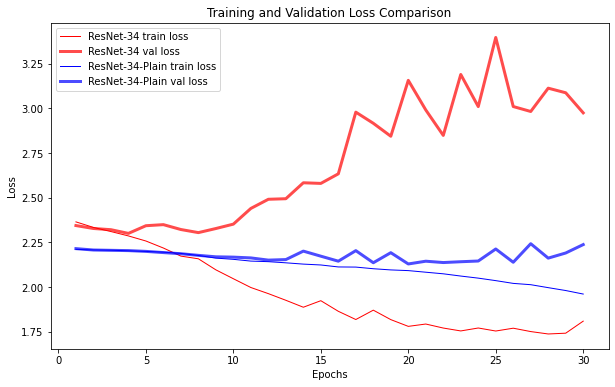

In [27]:
compare_history_loss(resnet_34_history, resnet_34_plain_history, 'ResNet-34', 'ResNet-34-Plain')

- train loss 값은 resnet이 더 낮게 나오지만 val loss는 오히려 resnet model에서 발산하는 형태를 보인다....

- resnet model은 plain 모델과는 다르게 많은 파라미터 수를 가지고 학습을 진행하게 되어 plain 모델보다 더 빠른 epochs에 과대적합되 부분을 볼 수 있다.

- dropout를 쓰지 않아서 빠르게 과대 적합 됐을 수 있다.

- 실험 조건에서 두 개의 모델이 optimizer한 상태가 아니여서 이 값을 보고 비교하는게 정당한 비교는 아닌거 같다.

- ealry stoppinp을 걸어 그 ealry stopping 된 부분의 그래프를 가지고 비교해 봐야겠다.


- 2번 째 실험에서는 dropout 비율 0.5로 실험을 해보고 결과를 관찰해 봐야겠다.

In [40]:
resnet_50 = ResNet(model_type=ResNetModels.RESNET_50)

In [41]:
resnet_50.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
resnet_50_history= resnet_50.fit(ds_train, epochs = 100, validation_data = ds_test)

Epoch 1/100
 194/1164 [====>.........................] - ETA: 1:25 - loss: 6.0210 - accuracy: 0.5354

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:20 - loss: 6.0178 - accuracy: 0.5357

 275/1164 [======>.......................] - ETA: 1:18 - loss: 6.0169 - accuracy: 0.5373

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 423/1164 [=========>....................] - ETA: 1:05 - loss: 6.0130 - accuracy: 0.5352

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1164 [====================>.........] - ETA: 28s - loss: 6.0074 - accuracy: 0.5444

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 26s - loss: 6.0076 - accuracy: 0.5439

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1164 [=====================>........] - ETA: 24s - loss: 6.0072 - accuracy: 0.5449

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1164 [=======================>......] - ETA: 19s - loss: 6.0070 - accuracy: 0.5459

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 953/1164 [=======================>......] - ETA: 18s - loss: 6.0068 - accuracy: 0.5460

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 6.0061 - accuracy: 0.5451

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 94ms/step - loss: 6.0061 - accuracy: 0.5451 - val_loss: 5.9998 - val_accuracy: 0.5469

Epoch 00001: saving model to ./checkpoints/resnet50_epoch_01_val_acc_0.55.h5
에폭 1의 히스토리가 저장되었습니다: ./checkpoints/resnet50_history_epoch_1.pkl
Epoch 2/100
 193/1164 [===>..........................] - ETA: 1:24 - loss: 6.0024 - accuracy: 0.5402

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:19 - loss: 6.0014 - accuracy: 0.5428

 280/1164 [======>.......................] - ETA: 1:16 - loss: 5.9992 - accuracy: 0.5462

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 423/1164 [=========>....................] - ETA: 1:04 - loss: 5.9990 - accuracy: 0.5504

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1164 [====================>.........] - ETA: 28s - loss: 5.9964 - accuracy: 0.5536

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1164 [=====================>........] - ETA: 26s - loss: 5.9966 - accuracy: 0.5535

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1164 [=====================>........] - ETA: 24s - loss: 5.9960 - accuracy: 0.5548

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 939/1164 [=======================>......] - ETA: 19s - loss: 5.9960 - accuracy: 0.5562

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1164 [=======================>......] - ETA: 18s - loss: 5.9963 - accuracy: 0.5554

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.9947 - accuracy: 0.5591

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 114s 96ms/step - loss: 5.9947 - accuracy: 0.5591 - val_loss: 5.9905 - val_accuracy: 0.5847

Epoch 00002: saving model to ./checkpoints/resnet50_epoch_02_val_acc_0.58.h5
에폭 2의 히스토리가 저장되었습니다: ./checkpoints/resnet50_history_epoch_2.pkl
Epoch 3/100
 195/1164 [====>.........................] - ETA: 1:24 - loss: 5.9945 - accuracy: 0.5619

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1164 [=====>........................] - ETA: 1:19 - loss: 5.9923 - accuracy: 0.5664

 280/1164 [======>.......................] - ETA: 1:16 - loss: 5.9897 - accuracy: 0.5708

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1164 [=========>....................] - ETA: 1:04 - loss: 5.9897 - accuracy: 0.5709

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 836/1164 [====================>.........] - ETA: 28s - loss: 5.9892 - accuracy: 0.5689

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1164 [=====================>........] - ETA: 26s - loss: 5.9888 - accuracy: 0.5695

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 24s - loss: 5.9888 - accuracy: 0.5692

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 19s - loss: 5.9884 - accuracy: 0.5707

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 18s - loss: 5.9885 - accuracy: 0.5703

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.9876 - accuracy: 0.5728

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 111s 93ms/step - loss: 5.9876 - accuracy: 0.5728 - val_loss: 5.9837 - val_accuracy: 0.5806

Epoch 00003: saving model to ./checkpoints/resnet50_epoch_03_val_acc_0.58.h5
에폭 3의 히스토리가 저장되었습니다: ./checkpoints/resnet50_history_epoch_3.pkl
Epoch 4/100
 195/1164 [====>.........................] - ETA: 1:24 - loss: 5.9822 - accuracy: 0.5766

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 252/1164 [=====>........................] - ETA: 1:19 - loss: 5.9789 - accuracy: 0.5848

 276/1164 [======>.......................] - ETA: 1:17 - loss: 5.9795 - accuracy: 0.5824

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1164 [==========>...................] - ETA: 1:04 - loss: 5.9794 - accuracy: 0.5815

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 836/1164 [====================>.........] - ETA: 28s - loss: 5.9796 - accuracy: 0.5822

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 861/1164 [=====================>........] - ETA: 26s - loss: 5.9797 - accuracy: 0.5822

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1164 [=====================>........] - ETA: 24s - loss: 5.9790 - accuracy: 0.5832

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1164 [=======================>......] - ETA: 19s - loss: 5.9788 - accuracy: 0.5834

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1164 [=======================>......] - ETA: 18s - loss: 5.9785 - accuracy: 0.5837

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 5.9787 - accuracy: 0.5853

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 111s 93ms/step - loss: 5.9787 - accuracy: 0.5853 - val_loss: 5.9854 - val_accuracy: 0.5922

Epoch 00004: saving model to ./checkpoints/resnet50_epoch_04_val_acc_0.59.h5
에폭 4의 히스토리가 저장되었습니다: ./checkpoints/resnet50_history_epoch_4.pkl
Epoch 5/100
 191/1164 [===>..........................] - ETA: 1:24 - loss: 5.9751 - accuracy: 0.5802

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1164 [=====>........................] - ETA: 1:19 - loss: 5.9759 - accuracy: 0.5818

 260/1164 [=====>........................] - ETA: 1:18 - loss: 5.9759 - accuracy: 0.5817

In [ ]:
resnet_50_plain = ResNet(model_type = ResNetModels.RESNET_50_PLAIN)

In [ ]:
resnet_50_plain.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
resnet_50_plain_history = resnet_50_plain.fit(ds_train, epochs = 100, validation_data = ds_test)

In [ ]:
compare_history_loss(resnet_50_history, resnet_50_plain_history, 'ResNet-50', 'ResNet-50-Plain')

- resnet-50이 plain 모델보다 loss 값이 초기보다 높게 나왔다.... sgd로 랜덤한 지점을 찾아서 경사하강법으로 내려가서 초기에는 높게 나온거 같다.

## resnet model 그래프

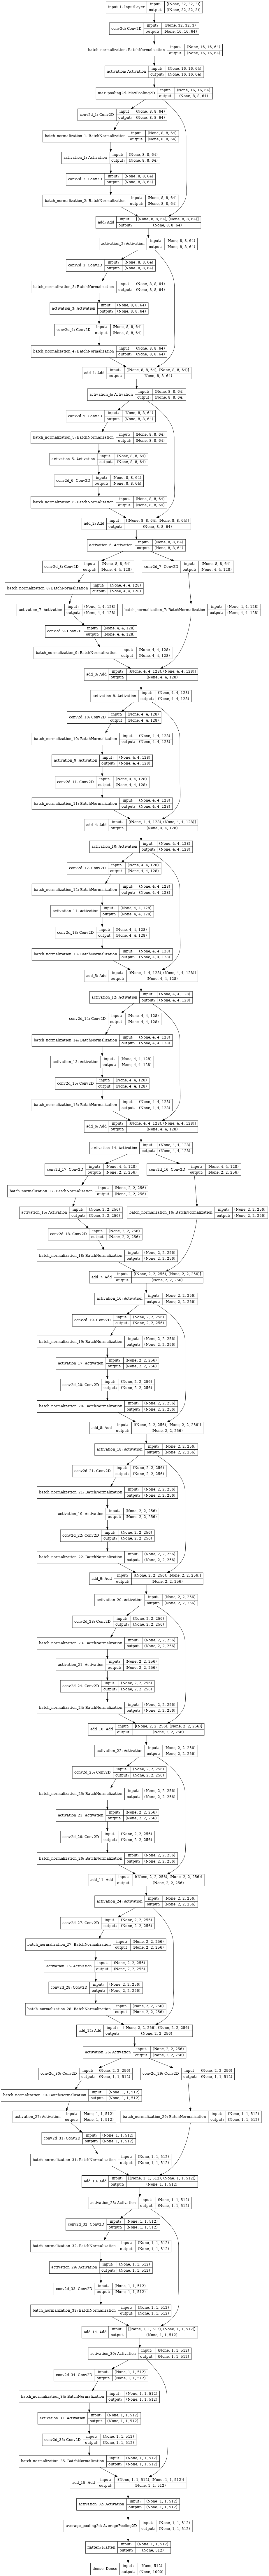

In [7]:
tf.keras.utils.plot_model(resnet_34.model, show_shapes=True, dpi=64)

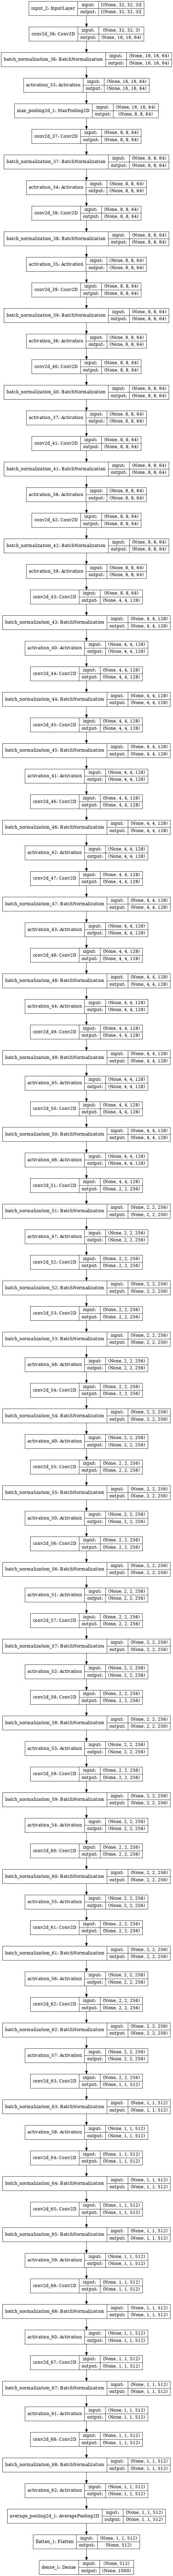

In [11]:
tf.keras.utils.plot_model(resnet_34_plain.model, show_shapes=True, dpi=64)

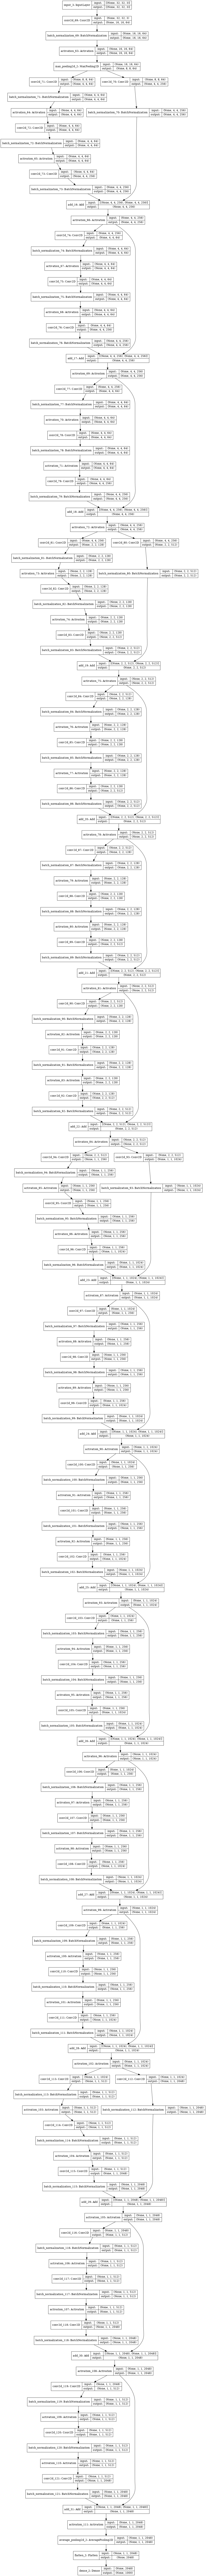

In [14]:
tf.keras.utils.plot_model(resnet_50.model,show_shapes=True, dpi = 64)

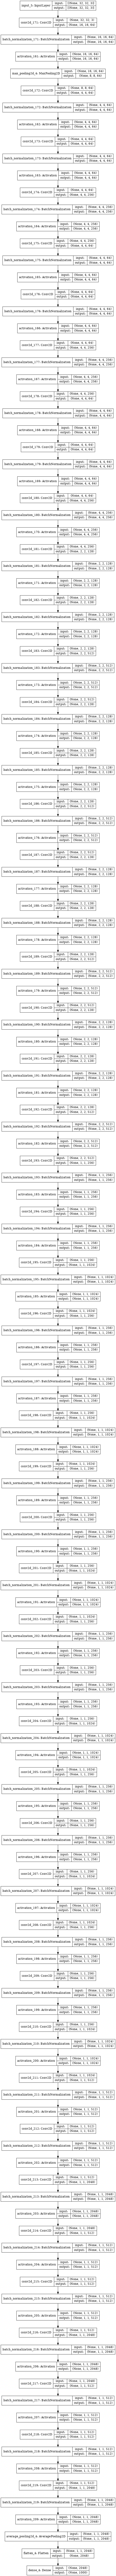

In [17]:
tf.keras.utils.plot_model(resnet_50_plain.model, show_shapes= True, dpi = 64)

## 회고
dl_ton 휴유증 때문에 노드 못 끝내면 잠이 안온다

노드에 있는 그대로 repeat 쓰니깐 내가 만든 class fit에서는 step_per_epochs = 0 이 나오는 문제가 생겼다. 앞으로 어떤 메서드인지 확인하고 써야겠다.

마지막 출력층에 1000 softmax를 해서 성능이 이상하게 나온걸까...